In [1]:
import datetime as dt
from datetime import date
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import pyproj
from shapely.ops import transform
import networkx as nx
import momepy

/home/twenty/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
routes = pd.read_csv('data/india/GTFS/routes.txt')

# Number of routes

In [3]:
routes.route_long_name.unique().shape

(1270,)

# Number of stops

In [4]:
stops = pd.read_csv('data/india/GTFS/stops.txt')

In [5]:
stops.stop_id.unique().shape

(4192,)

# Average number of stops per route

This is tricky because we need to associate between route_id and trip_id, but they do not have a dataset that directly connects them. Both do share a dataset with trip_ids however, so the data wrangling part is to:

1. Associate each trip with their stops (some trips might skip some stops)
2. Associate each route with trips on that route
3. For every route, get the unique stops for every trip

In [6]:
trips = pd.read_csv('data/india/GTFS/trips.txt')

In [7]:
stop_times = pd.read_csv('data/india/GTFS/stop_times.txt')

In [8]:
trip_to_stop_id = stop_times[['trip_id', 'stop_id']].drop_duplicates()
trip_to_stop_id

,trip_id,stop_id
0,1_07_00,23
1,1_07_00,24
2,1_07_00,25
3,1_07_00,26
4,1_07_00,27
...,...,...
2250285,1268_21_30,371
2250286,1268_21_30,372
2250287,1268_21_30,1736
2250288,1268_21_30,1738


In [9]:
route_to_trip_id = trips[['route_id', 'trip_id']].drop_duplicates()
route_to_trip_id

,route_id,trip_id
0,0,0_20_20
1,0,0_20_30
2,0,0_20_40
3,0,0_20_50
4,0,0_21_00
...,...,...
50350,9,9_21_10
50351,9,9_21_20
50352,9,9_21_30
50353,9,9_21_40


In [10]:
def f(x):
    '''
    input: dataframe with columns trip_id and stop_id. the trip_id has only one unique value
    output: list of all stop ids that this trip stops at
    '''
    return x.stop_id.to_list()

trip_stops = trip_to_stop_id.groupby('trip_id').apply(f)
trip_stops

trip_id
0_20_20    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
0_20_30    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
0_20_40    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
0_20_50    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
0_21_00    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
                                 ...                        
9_21_10    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
9_21_20    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
9_21_30    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
9_21_40    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
9_21_50    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
Length: 50355, dtype: object

In [11]:
def g(x):
    '''Same as `f` above but collects trip ids instead of stop ids'''
    return x.trip_id.to_list()

route_trips = route_to_trip_id.groupby('route_id').apply(g)
route_trips

route_id
0       [0_20_20, 0_20_30, 0_20_40, 0_20_50, 0_21_00, ...
1       [1_07_00, 1_07_10, 1_07_20, 1_07_30, 1_07_40, ...
2                                      [2_06_10, 2_06_20]
3       [3_10_30, 3_10_50, 3_11_10, 3_11_20, 3_11_30, ...
4       [4_06_00, 4_06_10, 4_06_50, 4_07_00, 4_07_10, ...
                              ...                        
1265    [1265_06_00, 1265_06_10, 1265_06_20, 1265_06_3...
1266    [1266_06_10, 1266_06_30, 1266_07_20, 1266_07_3...
1267    [1267_06_20, 1267_06_30, 1267_06_40, 1267_06_5...
1268    [1268_14_30, 1268_14_50, 1268_15_00, 1268_15_5...
1269    [1269_17_40, 1269_17_50, 1269_18_10, 1269_18_3...
Length: 1187, dtype: object

In [12]:
def h(x):
    '''
    input: a list of trip_ids (a single route has multiple trips)
    output: the set of stop_ids that every trip stops at
    '''
    # FIXME: picking the first trip for now
    return trip_stops[x[0]]
    #return [trip_stops[trip_id] for trip_id in x]
    #result = set()
    #for trip_id in x:
    #    result.update(trip_stops[trip_id])
    #return result

route_to_stops = route_trips.apply(h)
route_to_stops

route_id
0       [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
1       [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...
2                            [69, 70, 71, 72, 73, 74, 75]
3       [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...
4       [104, 105, 106, 24, 25, 27, 28, 29, 30, 31, 32...
                              ...                        
1265    [2593, 967, 968, 969, 970, 971, 972, 415, 416,...
1266    [937, 2388, 2416, 2417, 2418, 2419, 2420, 334,...
1267    [3159, 829, 830, 831, 832, 833, 834, 835, 836,...
1268    [111, 1480, 1481, 671, 1482, 790, 791, 792, 79...
1269    [3155, 3156, 3157, 3158, 579, 580, 934, 581, 5...
Length: 1187, dtype: object

In [13]:
num_stops_for_every_route = route_to_stops.apply(len)
num_stops_for_every_route

route_id
0       20
1       46
2        7
3       28
4       31
        ..
1265    24
1266    62
1267    47
1268    89
1269    57
Length: 1187, dtype: int64

In [14]:
# Average number of stops
num_stops_for_every_route.mean()

39.20134793597304

<AxesSubplot:ylabel='Frequency'>

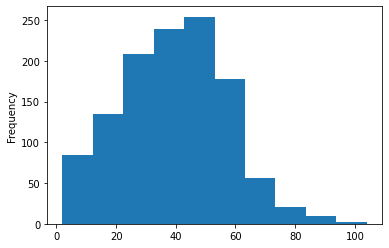

In [15]:
num_stops_for_every_route.plot.hist()

# Average route length

stops.txt: stop_lon, stop_lat

routes.txt: route_id

result: {route_id: [(stop_lon, stop_lat)] for route_id in route_ids}

In [16]:
# wgs84 is in degrees, pseudo mercator is in meters
wgs84 = pyproj.CRS('EPSG:4326')
pseudo_mercator = pyproj.CRS('EPSG:3857')
project = pyproj.Transformer.from_crs(wgs84, pseudo_mercator, always_xy=True).transform

def transformer(p: Point):
    return transform(project, p)

In [17]:
# def z(x):
#     res = []
#     for stop in x:
#         df = stops[stops.stop_id == stop]
#         res.append((df.stop_lon.iloc[0], df.stop_lat.iloc[0]))
#     return res

# route_to_stops.apply(z)

In [18]:
# TODO this is rather slow too
def z(x):
    res = []
    for stop in x:
        df = stops[stops.stop_id == stop]
        x_c = df.stop_lon.iloc[0]
        y_c = df.stop_lat.iloc[0]
        res.append(transformer(Point(x_c, y_c)))
    return res

route_stop_coords = route_to_stops.apply(z)
route_stop_coords

route_id
0       [POINT (8581937.473719167 3357553.47980293), P...
1       [POINT (8588110.028164163 3344921.146539369), ...
2       [POINT (8563883.233424349 3327151.778796668), ...
3       [POINT (8567644.38505978 3336016.868613827), P...
4       [POINT (8586888.630711177 3343268.200248517), ...
                              ...                        
1265    [POINT (8575356.265423467 3337231.959639902), ...
1266    [POINT (8605369.892572677 3311301.320233013), ...
1267    [POINT (8596507.699449476 3330137.928757219), ...
1268    [POINT (8596967.831366071 3332453.453836878), ...
1269    [POINT (8588009.72930296 3353671.051255993), P...
Length: 1187, dtype: object

In [19]:
route_lengths = route_stop_coords.apply(lambda x: LineString(x).length)
route_lengths

route_id
0       12877.486982
1       30744.084545
2        8262.196860
3       22570.834831
4       18806.029158
            ...     
1265    18061.321531
1266    33703.261014
1267    26941.728181
1268    62078.381617
1269    35559.108203
Length: 1187, dtype: float64

In [20]:
# Average route length in meters
route_lengths.mean()

24261.984206622277

<AxesSubplot:ylabel='Frequency'>

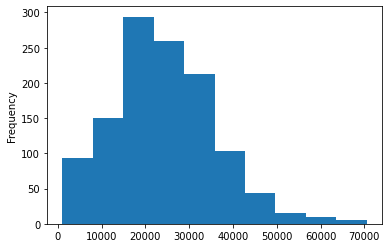

In [21]:
route_lengths.plot.hist()

# Average distance between stops

In [22]:
def calc_distances(x):
    '''
    input: [(float, float)]
        a list of coordinates
    output: [float]
        the distances between each coordinates
    '''
    return [Point(a).distance(Point(b)) for a, b in zip(x, x[1:])]

In [23]:
route_stop_dists = route_stop_coords.apply(calc_distances)
route_stop_dists

route_id
0       [321.9643107629447, 254.33472327080472, 328.21...
1       [1077.611570766103, 1308.7206422144516, 682.18...
2       [2020.2658950779826, 623.7750065142687, 859.07...
3       [711.0090631376837, 838.3606140627169, 182.089...
4       [654.088515675464, 413.42850309023015, 1035.52...
                              ...                        
1265    [649.5618948508355, 811.2861075045431, 635.039...
1266    [460.9534022689515, 721.8964800311446, 662.902...
1267    [395.9212770547474, 790.2810089899889, 863.785...
1268    [1127.1261640060252, 407.7244321184896, 750.50...
1269    [1525.65917367137, 904.4373248370265, 1027.147...
Length: 1187, dtype: object

In [24]:
route_avg_stop_dists = route_stop_dists.apply(np.mean)
route_avg_stop_dists

route_id
0        677.762473
1        683.201879
2       1377.032810
3        835.956846
4        626.867639
           ...     
1265     785.274849
1266     552.512476
1267     585.689743
1268     705.436155
1269     634.984075
Length: 1187, dtype: float64

In [25]:
# Global average distance between stops (TODO: what units?)
route_avg_stop_dists.mean()

650.4444398735006

<AxesSubplot:ylabel='Frequency'>

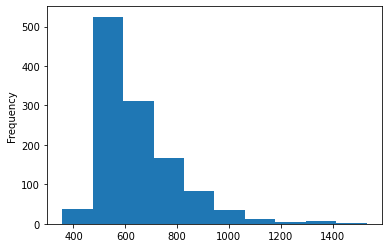

In [26]:
route_avg_stop_dists.plot.hist()

<AxesSubplot:ylabel='Frequency'>

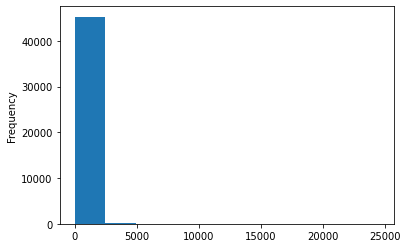

In [27]:
# The individual distances between every stops in every route
route_stop_dists.explode().plot.hist()

# Median bus speed

Removed because some stops don't have an associated stop time:

In [28]:
np.setdiff1d(stops.stop_id.unique(), stop_times.stop_id.unique())

array([1730, 1731, 2443, 2444, 3128, 3129, 3130, 3131, 3132, 3134, 3747,
       3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3832, 3833, 3834,
       3835, 3836, 3837, 3855, 3914, 3935, 3947, 3948, 3949, 3950, 4104,
       4143])

In [29]:
stop_times[stop_times.stop_id == 1730]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence


In [30]:
stops[stops.stop_id == 1730]

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id
1713,1730,DC4019,Dauralla Border,28.507925,76.896927,1730


# Number of links

# Number of nodes

# Network diameter

In [31]:
def z(x):
    res = []
    for stop in x:
        df = stops[stops.stop_id == stop]
        res.append((df.stop_lon.iloc[0], df.stop_lat.iloc[0]))
    return res

route_stop_coords = route_to_stops.apply(z)
route_stop_coords

route_id
0       [(77.09285600000003, 28.857752), (77.095745999...
1       [(77.14830500000002, 28.758318), (77.150774, 2...
2       [(76.930672, 28.618288), (76.94478225753659, 2...
3       [(76.96445899999998, 28.688172), (76.9708, 28....
4       [(77.137333, 28.7453), (77.14307600000002, 28....
                              ...                        
1265    [(77.033736, 28.697747), (77.027902, 28.697847...
1266    [(77.303353, 28.493222), (77.302417, 28.496767...
1267    [(77.2237425646661, 28.6418331891737), (77.224...
1268    [(77.227876, 28.660087), (77.2181, 28.6624), (...
1269    [(77.14740400000002, 28.827202000000003), (77....
Length: 1187, dtype: object

In [32]:
route_stop_coords_dict = route_stop_coords.to_dict()

In [33]:
g = nx.from_dict_of_lists(route_stop_coords_dict)

In [34]:
nx.algorithms.distance_measures.diameter(g)

10

## Trying to use Point instead of coord... but too slow

In [35]:
route_stop_coords_df = pd.DataFrame(route_stop_coords, columns=['coords']).explode('coords')
route_stop_coords_df

,coords
route_id,
0,"(77.09285600000003, 28.857752)"
0,"(77.09574599999998, 28.857652)"
0,"(77.097951, 28.857128000000003)"
0,"(77.09790699999998, 28.85454600000001)"
0,"(77.097849, 28.85177100000001)"
...,...
1269,"(77.028059, 28.712614)"
1269,"(77.028, 28.7095)"
1269,"(77.02789, 28.70358)"


In [36]:
route_stop_coords_df.coords = route_stop_coords_df.coords.apply(Point)

In [37]:
route_stop_coords_gdf = gpd.GeoDataFrame(route_stop_coords_df)
route_stop_coords_gdf

,coords
route_id,
0,POINT (77.09285600000003 28.857752)
0,POINT (77.09574599999998 28.857652)
0,POINT (77.09795099999999 28.857128)
0,POINT (77.09790699999998 28.85454600000001)
0,POINT (77.097849 28.85177100000001)
...,...
1269,POINT (77.028059 28.712614)
1269,POINT (77.02800000000001 28.7095)
1269,POINT (77.02789 28.70358)


In [38]:
route_stop_coords_gdf.geometry = route_stop_coords_gdf.coords

In [39]:
G = momepy.gdf_to_nx(route_stop_coords_gdf)

In [40]:
#nx.draw(G)

# Network density

In [41]:
nx.classes.function.density(g)

0.0033170887927784468